# QAL-BP: An Augmented Lagrangian Quantum Approach for Bin Packing

This notebook demonstrates the pipeline of solving the Bin Packing problem using QAL-BP.

Consider that when using Quantum Annealing results may stongly vary from one run to another, influencing also the benchmark analysis.

**IMPORTANT: before running this notebook create a config.py file with the variable dimod.token="your_token" in the same folder of the notebook**

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  !git clone https://github.com/Lorenz92/QAL-BP.git

Cloning into 'QAL-BP'...
remote: Enumerating objects: 267, done.
remote: Counting objects: 100% (267/267), done.
remote: Compressing objects: 100% (233/233), done.
remote: Total 267 (delta 49), reused 249 (delta 31), pack-reused 0
Receiving objects: 100% (267/267), 6.28 MiB | 26.04 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [2]:
%cd QAL-BP/
!ls

/content/QAL-BP
gurobi_df_40_instances.csv  QAL_BP.ipynb	README.md  utils.py
__pycache__		    QAL_BP_plots.ipynb	results


## Install and Import Dependencies

In [4]:
# If this notebook is running on Windows OS, change apt with tlmgr
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
!pip install SciencePlots

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-cantarell fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-core fonts-dejavu-extra
  fonts-droid-fallback fonts-ebgaramond fonts-ebgaramond-extra fonts-font-awesome
  fonts-freefont-otf fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-neohellenic fonts-gfs-olga fonts-gfs-solomos fonts-go fonts-junicode fonts-lato
  fonts-linuxlibertine fonts-lmodern fonts-lobster fonts-lobstertwo fonts-noto-color-emoji
  fonts-noto-core fonts-noto-mono fonts-oflb-asana-math fonts-open-sans fonts-roboto-unhinted
  fonts-sil-charis fonts-sil-gentium fonts-sil-gentium-basic fonts-sil-gentiumplus
  fonts-sil-gentiumplus-compact fonts-stix fonts-texgyre fo

In [28]:
import pandas as pd
import shutil
import gc
import time
import os
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np
import scienceplots

%matplotlib inline

json_path = './solutions/'
results_path = './results/'

seeds = [23, 42, 123, 90, 510]
chain_strength_list = [10, 6, 'scaled', 'uniform_torque_compensation']
chain_strength_param = chain_strength_list[3]

dpi = 300
fontsize = 11

color_scheme = {
    'QA':'#DB222A',
    'SA':'#FFC53A',
    'Gurobi':'#118AB2',
    'Ex':'#01172F',
    'color5':'#06D6A0',
    'color6':'#46ACC2',
    'color7':'#E88873',
    'color8':'#4C212A',
    'color9':'#0EAD69',
    'color10':'#058ED9',
    'color11':'#484548'
}

# Plots from the notebook QAL-BP.ipynb

## Chain strength plots

In [6]:
df_final_QA_cs_methods = pd.DataFrame()
cols = ['instance_name', 'seed', 'AL_QA_min_eigenvalue', 'AL_QA_cbf', 'AL_QA_chain_strength_sample', 'AL_QA_chain_strength_method']

for i in chain_strength_list:
  df_read = pd.read_csv(f'{results_path}/results_w_cs/{str(i)}/df_final_QA.csv', index_col=0, usecols = cols)
  df_read.rename(columns=lambda x: x + '_' + str(i), inplace=True)
  df_final_QA_cs_methods = pd.concat([df_final_QA_cs_methods, df_read], axis = 1)

df_final_QA_cs_methods = df_final_QA_cs_methods.loc[:,~df_final_QA_cs_methods.columns.duplicated()].reset_index()
df_final_QA_cs_methods.head()

,instance_name,seed_10,AL_QA_min_eigenvalue_10,AL_QA_cbf_10,AL_QA_chain_strength_sample_10,AL_QA_chain_strength_method_10,seed_6,AL_QA_min_eigenvalue_6,AL_QA_cbf_6,AL_QA_chain_strength_sample_6,...,seed_scaled,AL_QA_min_eigenvalue_scaled,AL_QA_cbf_scaled,AL_QA_chain_strength_sample_scaled,AL_QA_chain_strength_method_scaled,seed_uniform_torque_compensation,AL_QA_min_eigenvalue_uniform_torque_compensation,AL_QA_cbf_uniform_torque_compensation,AL_QA_chain_strength_sample_uniform_torque_compensation,AL_QA_chain_strength_method_uniform_torque_compensation
0,bpp_3_10,23,0.1334,0.0,10,10,23,0.1334,0.0,6,...,23,0.1334,0.0,2.69520,scaled,23,0.1334,0.0,2.726130,uniform_torque_compensation
1,bpp_4_10,23,0.0059,0.0,10,10,23,0.0059,0.0,6,...,23,0.0059,0.0,4.00105,scaled,23,0.0059,0.0,3.078706,uniform_torque_compensation
2,bpp_5_10,23,-0.0107,0.0,10,10,23,-0.0107,0.0,6,...,23,-0.0107,0.0,6.50215,scaled,23,-0.0107,0.0,3.623217,uniform_torque_compensation
3,bpp_6_10,23,0.3625,0.0,10,10,23,0.2115,0.0,6,...,23,0.2115,0.0,7.36320,scaled,23,0.2115,0.0,3.714758,uniform_torque_compensation
4,bpp_7_10,23,0.9024,0.0,10,10,23,0.5376,0.0,6,...,23,1.2672,0.0,7.86360,scaled,23,0.5376,0.0,3.738291,uniform_torque_compensation


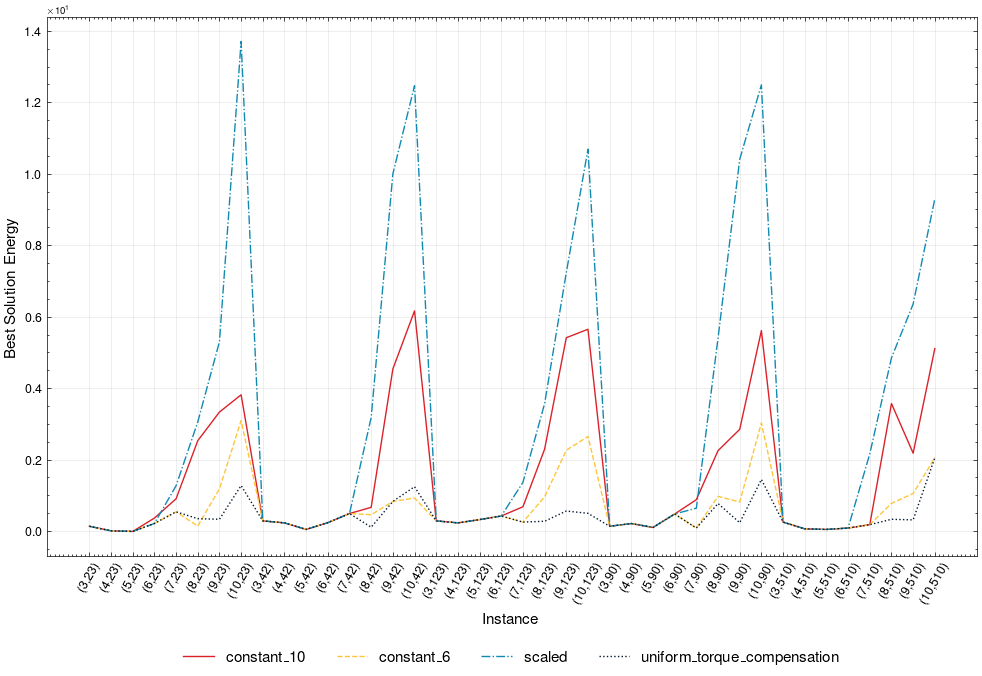

In [12]:
plt.style.use(['science', 'nature'])
font = 11
runtime = [col for col in df_final_QA_cs_methods.columns if '_eigenvalue' in col]
N = 40
ind = np.arange(N)

# Legend labels for different solvers
leg = {
        '10' : 'constant_10',
        '6' : 'constant_6',
        'scaled' : 'scaled',
        'compensation' : 'uniform_torque_compensation'
}

lines = ["-","--","-.",":"]
linecycler = cycle(lines)

plt.figure(figsize=(12, 7))

# Plot runtime metrics
for i, r in enumerate(runtime):
  plt.plot(ind, df_final_QA_cs_methods.loc[:, r], label=leg[r.split('_')[-1]], linestyle=next(linecycler), color=list(color_scheme.values())[i])


plt.xticks(ind, '('+df_final_QA_cs_methods['instance_name'].apply(lambda x: x.split('_')[1])+','+df_final_QA_cs_methods['seed_10'].astype(str)+')', fontsize=fontsize, rotation=60)
plt.grid(alpha=0.3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(fontsize=font)
plt.tick_params(labelsize=9)
plt.xlabel('Instance', fontsize=font)
plt.ylabel('Best Solution Energy', fontsize=font)
plt.legend(fontsize=font, loc='upper center', bbox_to_anchor=(0.5, -.15), ncol=4)
plt.savefig("energy_vs_chain_strength.png", dpi=dpi)
plt.show()


In [14]:
# Read the previously saved results

df_final_SA = pd.read_csv(f'./results/AL/df_final_SA.csv',index_col=0)
df_final_QA = pd.read_csv(f'./results/AL/df_final_QA.csv',index_col=0)
df_final_Ex = pd.read_csv('./results/AL/df_final_Ex.csv',index_col=0)

## Solutions

What follows is a comparison of the number of bins in solutions obtained by different solvers.

The graphs compares the number of bins in solutions generated by Gurobi, Simulated Annealing (SA), and
Quantum Annealing (QA) solvers for the given set of instances.

In [16]:
df_final_SA['gurobi_n_bins'] = df_final_SA['gurobi_n_bins'].astype(int)

df_final_SA['AL_SA_n_bins'] = df_final_SA['AL_SA_yi'].apply(lambda x:  len(x.strip("'][").replace("'",'').split(', ')))
df_final_QA['AL_QA_n_bins'] = df_final_QA['AL_QA_yi'].apply(lambda x:  len(x.strip("'][").replace("'",'').split(', ')))

df_num_bins_SA = df_final_SA[['instance_name','seed', 'gurobi_n_bins', 'AL_SA_n_bins']]
df_num_bins_QA = df_final_QA[['instance_name','seed','AL_QA_n_bins']]

df_num_bins = pd.concat([df_num_bins_SA, df_num_bins_QA], axis = 1)
df_num_bins = df_num_bins.loc[:,~df_num_bins.columns.duplicated()]

print(df_num_bins.shape)
df_num_bins.head()

(40, 5)


,instance_name,seed,gurobi_n_bins,AL_SA_n_bins,AL_QA_n_bins
0,bpp_3_10,23,2,2,2
1,bpp_4_10,23,3,3,3
2,bpp_5_10,23,4,4,4
3,bpp_6_10,23,4,4,4
4,bpp_7_10,23,7,7,7


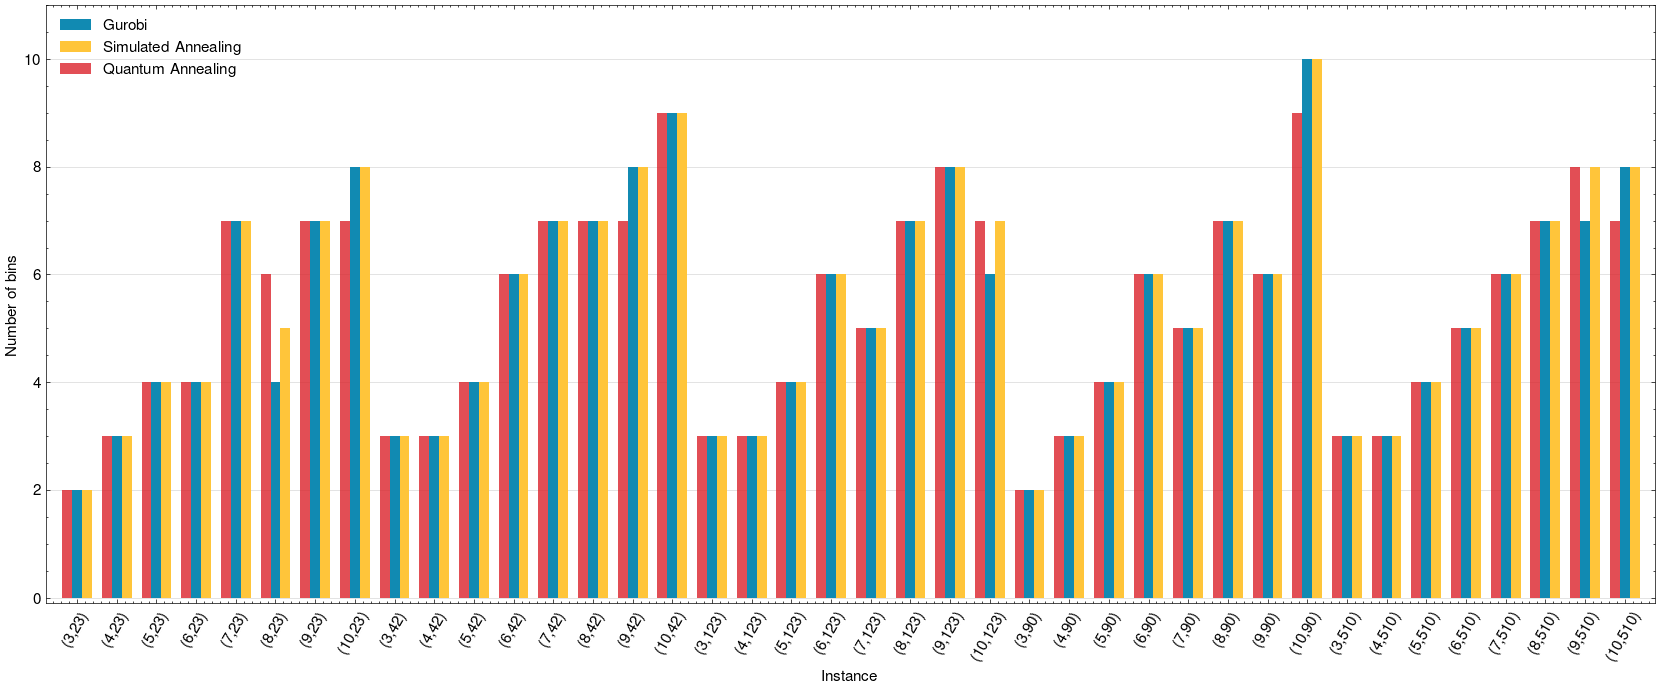

In [17]:
N = 40
ind = np.arange(N)  # the x locations for the groups
width = 0.25        # the width of the bars

plt.style.use(['science', 'nature'])

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
plt.grid(axis='y', alpha=0.5, zorder=1)
rects1 = ax.bar(ind, df_num_bins['gurobi_n_bins'], width, color=color_scheme['Gurobi'], zorder=3)
rects2 = ax.bar(ind + width, df_num_bins['AL_SA_n_bins'], width, color=color_scheme['SA'], zorder=3)
rects3 = ax.bar(ind - width, df_num_bins['AL_QA_n_bins'], width, color=color_scheme['QA'], zorder=3, alpha=0.8)

# Add labels and titles
ax.set_ylabel('Number of bins', fontsize=fontsize)
ax.set_xlabel('Instance', fontsize=fontsize)
ax.set_ylim(-0.1, 11)
ax.set_xticks(ind)
ax.set_xticklabels('('+df_num_bins['instance_name'].apply(lambda x: x.split('_')[1])+','+df_num_bins['seed'].astype(str)+')', fontsize=fontsize)
plt.xticks(rotation=60)
plt.yticks(fontsize=fontsize)

plt.gca().margins(x=0.01)
plt.gcf().canvas.draw()
tl = plt.gca().get_xticklabels()
maxsize = max([t.get_window_extent().width for t in tl])
m = 0.2  # inch margin
s = maxsize / plt.gcf().dpi * N + 2 * m
margin = m / plt.gcf().get_size_inches()[0]

plt.gcf().subplots_adjust(left=margin, right=1. - margin)
plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

ax.legend((rects1[0], rects2[0], rects3[0]), ('Gurobi', 'Simulated Annealing', 'Quantum Annealing'), loc='upper left', fontsize=fontsize)
plt.tight_layout()

plt.savefig("num_bins.png", dpi=dpi)
plt.show()

## Complexity plot

The following cell generate a plot illustrating the model complexity with respect to the number of items and bin capacity.

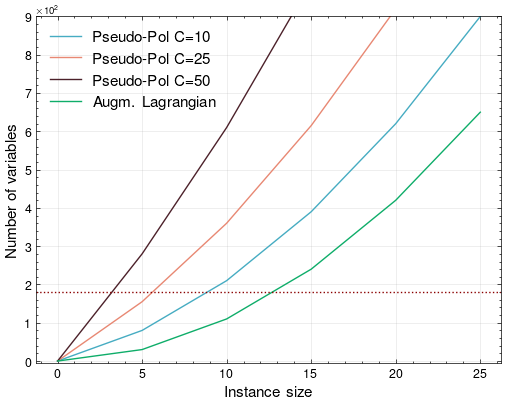

In [18]:
plt.style.use(['science', 'nature'])

c = [10, 25, 50]
pseudopol_10 = []
pseudopol_25 = []
pseudopol_50 = []
al = []
nitem = []

# Calculate model complexities for different numbers of items
for n in range(0, 30, 5):
    nitem.append(n)
    pseudopol_10.append(n * (n + 1 + c[0]))
    pseudopol_25.append(n * (n + 1 + c[1]))
    pseudopol_50.append(n * (n + 1 + c[2]))
    al.append(n * (n + 1))

# Create the plot
plt.figure(figsize=(6, 4.5))

plt.plot(nitem, pseudopol_10, label='Pseudo-Pol C=10', color=color_scheme['color6'])
plt.plot(nitem, pseudopol_25, label='Pseudo-Pol C=25', color=color_scheme['color7'])
plt.plot(nitem, pseudopol_50, label='Pseudo-Pol C=50', color=color_scheme['color8'])
plt.plot(nitem, al, label='Augm. Lagrangian', color=color_scheme['color9'])
plt.axhline(180, color='darkred', linestyle='dotted')

plt.xlabel('Instance size', fontsize=fontsize)
plt.ylabel('Number of variables', fontsize=fontsize)
plt.ylim(-5, 250)
plt.grid(alpha=0.3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(fontsize=fontsize)
plt.xticks(np.arange(0, 30, 5), fontsize=fontsize)
plt.yticks(np.arange(0, 1000, 100), fontsize=fontsize)
plt.tick_params(labelsize=9)
plt.savefig('num_vars_n.png', dpi=dpi)
plt.show()

## Runtime

The following cells create a plot to illustrate the runtime performance of the QAL-BPP model for various problem instances. It compares the runtime results for different solvers,
including Gurobi, Simulated Annealing (SA) with Augmented Lagrangian (AL) and Quantum Annealing (QA) with Augmented Lagrangian (AL).


In [19]:
df_mean_std_runtime_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_QA_runtime'].agg(['mean', 'std'])
df_mean_std_runtime_QA.columns = df_mean_std_runtime_QA.columns.map('_'.join)
display(df_mean_std_runtime_QA)

df_mean_std_runtime_SA = df_final_SA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_SA_runtime'].agg(['mean', 'std'])
df_mean_std_runtime_SA.columns = df_mean_std_runtime_SA.columns.map('_'.join)
display(df_mean_std_runtime_SA)

df_mean_std_runtime_Ex = df_final_Ex.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_Ex_runtime'].agg(['mean', 'std'])
df_mean_std_runtime_Ex.columns = df_mean_std_runtime_Ex.columns.map('_'.join)
display(df_mean_std_runtime_Ex)

df_mean_std_runtime = pd.concat([df_mean_std_runtime_SA, df_mean_std_runtime_QA, df_mean_std_runtime_Ex], axis = 1)
df_mean_std_runtime = df_mean_std_runtime.loc[:,~df_mean_std_runtime.columns.duplicated()].reset_index()
display(df_mean_std_runtime)

<ipython-input-19-04325199534e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_QA_runtime'].agg(['mean', 'std'])


,,gurobi_runtime_mean,gurobi_runtime_std,AL_QA_runtime_mean,AL_QA_runtime_std
instance_name,n,,,,
bpp_3_10,3,675.6584,417.129559,122908.0,18100.721533
bpp_4_10,4,725.8646,208.672415,112896.0,9356.488658
bpp_5_10,5,771.0808,158.286861,129504.0,37251.776870
bpp_6_10,6,1201.2872,1116.704614,138624.0,47217.599261
bpp_7_10,7,866.6642,98.711861,173888.0,27245.853262
bpp_8_10,8,2527.2990,1625.870810,167736.0,34790.131934
bpp_9_10,9,1872.1488,574.534788,161800.0,29347.238371
bpp_10_10,10,2722.4716,765.501704,215120.0,18096.601891


<ipython-input-19-04325199534e>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_SA = df_final_SA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_SA_runtime'].agg(['mean', 'std'])


,,gurobi_runtime_mean,gurobi_runtime_std,AL_SA_runtime_mean,AL_SA_runtime_std
instance_name,n,,,,
bpp_3_10,3,451.2,35.877570,2.348397e+05,55205.274602
bpp_4_10,4,743.4,228.103704,3.868659e+05,78500.956277
bpp_5_10,5,835.0,256.008789,5.857823e+05,130499.360486
bpp_6_10,6,1057.4,301.958275,8.058050e+05,176401.489342
bpp_7_10,7,2879.4,3580.310084,1.116202e+06,232599.512484
bpp_8_10,8,2946.2,2367.598931,1.395239e+06,334664.742172
bpp_9_10,9,1784.2,461.837850,2.014631e+06,635209.674661
bpp_10_10,10,3051.4,539.289162,2.230404e+06,530436.583023


<ipython-input-19-04325199534e>:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_Ex = df_final_Ex.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_Ex_runtime'].agg(['mean', 'std'])


,,gurobi_runtime_mean,gurobi_runtime_std,AL_Ex_runtime_mean,AL_Ex_runtime_std
instance_name,n,,,,
bpp_3_10,3,524.6,138.575972,1.331339e+04,9541.950851
bpp_4_10,4,773.8,306.236347,2.449602e+06,502457.992174
bpp_5_10,5,868.8,200.092978,1.000000e+13,0.000000
bpp_6_10,6,797.0,239.736313,1.000000e+13,0.000000
bpp_7_10,7,1065.2,219.202418,1.000000e+13,0.000000
bpp_8_10,8,2422.2,1386.158613,1.000000e+13,0.000000
bpp_9_10,9,1759.0,474.914729,1.000000e+13,0.000000
bpp_10_10,10,2618.4,712.045153,1.000000e+13,0.000000


,instance_name,n,gurobi_runtime_mean,gurobi_runtime_std,AL_SA_runtime_mean,AL_SA_runtime_std,AL_QA_runtime_mean,AL_QA_runtime_std,AL_Ex_runtime_mean,AL_Ex_runtime_std
0,bpp_3_10,3,451.2,35.877570,2.348397e+05,55205.274602,122908.0,18100.721533,1.331339e+04,9541.950851
1,bpp_4_10,4,743.4,228.103704,3.868659e+05,78500.956277,112896.0,9356.488658,2.449602e+06,502457.992174
2,bpp_5_10,5,835.0,256.008789,5.857823e+05,130499.360486,129504.0,37251.776870,1.000000e+13,0.000000
3,bpp_6_10,6,1057.4,301.958275,8.058050e+05,176401.489342,138624.0,47217.599261,1.000000e+13,0.000000
4,bpp_7_10,7,2879.4,3580.310084,1.116202e+06,232599.512484,173888.0,27245.853262,1.000000e+13,0.000000
5,bpp_8_10,8,2946.2,2367.598931,1.395239e+06,334664.742172,167736.0,34790.131934,1.000000e+13,0.000000
6,bpp_9_10,9,1784.2,461.837850,2.014631e+06,635209.674661,161800.0,29347.238371,1.000000e+13,0.000000
7,bpp_10_10,10,3051.4,539.289162,2.230404e+06,530436.583023,215120.0,18096.601891,1.000000e+13,0.000000


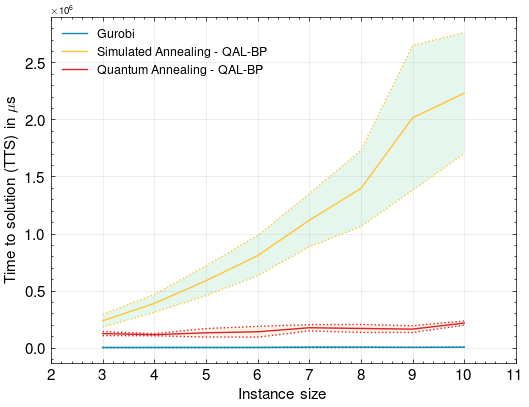

In [20]:
plt.style.use(['science', 'nature'])
runtime = [col for col in df_mean_std_runtime.columns if '_mean' in col]

# Legend labels for different solvers
leg = {
    'gurobi_runtime_mean': 'Gurobi',
    'AL_SA_runtime_mean': 'Simulated Annealing - QAL-BP',
    'AL_QA_runtime_mean': 'Quantum Annealing - QAL-BP'
}

color_link = {
    'gurobi_runtime_mean': 'Gurobi',
    'AL_SA_runtime_mean': 'SA',
    'AL_QA_runtime_mean': 'QA'
}

plt.figure(figsize=(6, 4.5))

# Plot TTS for different solvers
for i, r in enumerate(runtime[:3]):
    plt.plot(df_mean_std_runtime.loc[:, 'n'], df_mean_std_runtime.loc[:, r], color=color_scheme[color_link[r]], label=leg[r])
    r_std = f'{r[:-5]}_std'
    upper_stock = np.sum([np.round(df_mean_std_runtime.loc[:, r], 0), np.round(df_mean_std_runtime.loc[:, r_std], 0)], 0)
    lower_stock = np.sum([np.round(df_mean_std_runtime.loc[:, r], 0), -np.round(df_mean_std_runtime.loc[:, r_std], 0)], 0)
    plt.plot(df_mean_std_runtime.loc[:, 'n'], upper_stock, color=color_scheme[color_link[r]], linestyle='dotted')
    plt.plot(df_mean_std_runtime.loc[:, 'n'], lower_stock, color=color_scheme[color_link[r]], linestyle='dotted')

    plt.fill_between(df_mean_std_runtime.loc[:, 'n'], upper_stock, lower_stock, alpha=0.1)

plt.xlim(2, 11)
plt.grid(alpha=0.3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(fontsize=fontsize-2)
plt.tick_params(labelsize=fontsize)
plt.xlabel('Instance size', fontsize=fontsize)
plt.ylabel('Time to solution (TTS) in $\mu$s', fontsize=fontsize)
plt.savefig("tts.png", dpi=dpi)
plt.show()

In [21]:
# Same runtime plot but summing qubo embedding time to QA runtime
df_final_QA['AL_QA_runtime'] = df_final_QA['AL_QA_runtime'] + df_final_QA['AL_QA_qubo_time']

df_mean_std_runtime_total_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_QA_runtime'].agg(['mean', 'std'])
df_mean_std_runtime_total_QA.columns = df_mean_std_runtime_total_QA.columns.map('_'.join)
display(df_mean_std_runtime_total_QA)

df_mean_std_runtime_SA = df_final_SA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_SA_runtime'].agg(['mean', 'std'])
df_mean_std_runtime_SA.columns = df_mean_std_runtime_SA.columns.map('_'.join)
display(df_mean_std_runtime_SA)

df_mean_std_runtime_Ex = df_final_Ex.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_Ex_runtime'].agg(['mean', 'std'])
df_mean_std_runtime_Ex.columns = df_mean_std_runtime_Ex.columns.map('_'.join)
display(df_mean_std_runtime_Ex)

df_mean_std_runtime_total = pd.concat([df_mean_std_runtime_SA, df_mean_std_runtime_total_QA, df_mean_std_runtime_Ex], axis = 1)
df_mean_std_runtime_total = df_mean_std_runtime_total.loc[:,~df_mean_std_runtime_total.columns.duplicated()].reset_index()
display(df_mean_std_runtime_total)

<ipython-input-21-6c0cf0e83758>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_total_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_QA_runtime'].agg(['mean', 'std'])


,,gurobi_runtime_mean,gurobi_runtime_std,AL_QA_runtime_mean,AL_QA_runtime_std
instance_name,n,,,,
bpp_3_10,3,675.6584,417.129559,123165.539749,18096.203070
bpp_4_10,4,725.8646,208.672415,113411.890122,9308.198336
bpp_5_10,5,771.0808,158.286861,130378.280930,37065.770706
bpp_6_10,6,1201.2872,1116.704614,139763.402390,47170.368146
bpp_7_10,7,866.6642,98.711861,176119.884003,27421.312175
bpp_8_10,8,2527.2990,1625.870810,171023.124634,35193.282637
bpp_9_10,9,1872.1488,574.534788,165979.763794,30124.949089
bpp_10_10,10,2722.4716,765.501704,221060.866470,18840.937302


<ipython-input-21-6c0cf0e83758>:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_SA = df_final_SA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_SA_runtime'].agg(['mean', 'std'])


,,gurobi_runtime_mean,gurobi_runtime_std,AL_SA_runtime_mean,AL_SA_runtime_std
instance_name,n,,,,
bpp_3_10,3,451.2,35.877570,2.348397e+05,55205.274602
bpp_4_10,4,743.4,228.103704,3.868659e+05,78500.956277
bpp_5_10,5,835.0,256.008789,5.857823e+05,130499.360486
bpp_6_10,6,1057.4,301.958275,8.058050e+05,176401.489342
bpp_7_10,7,2879.4,3580.310084,1.116202e+06,232599.512484
bpp_8_10,8,2946.2,2367.598931,1.395239e+06,334664.742172
bpp_9_10,9,1784.2,461.837850,2.014631e+06,635209.674661
bpp_10_10,10,3051.4,539.289162,2.230404e+06,530436.583023


<ipython-input-21-6c0cf0e83758>:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_Ex = df_final_Ex.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_Ex_runtime'].agg(['mean', 'std'])


,,gurobi_runtime_mean,gurobi_runtime_std,AL_Ex_runtime_mean,AL_Ex_runtime_std
instance_name,n,,,,
bpp_3_10,3,524.6,138.575972,1.331339e+04,9541.950851
bpp_4_10,4,773.8,306.236347,2.449602e+06,502457.992174
bpp_5_10,5,868.8,200.092978,1.000000e+13,0.000000
bpp_6_10,6,797.0,239.736313,1.000000e+13,0.000000
bpp_7_10,7,1065.2,219.202418,1.000000e+13,0.000000
bpp_8_10,8,2422.2,1386.158613,1.000000e+13,0.000000
bpp_9_10,9,1759.0,474.914729,1.000000e+13,0.000000
bpp_10_10,10,2618.4,712.045153,1.000000e+13,0.000000


,instance_name,n,gurobi_runtime_mean,gurobi_runtime_std,AL_SA_runtime_mean,AL_SA_runtime_std,AL_QA_runtime_mean,AL_QA_runtime_std,AL_Ex_runtime_mean,AL_Ex_runtime_std
0,bpp_3_10,3,451.2,35.877570,2.348397e+05,55205.274602,123165.539749,18096.203070,1.331339e+04,9541.950851
1,bpp_4_10,4,743.4,228.103704,3.868659e+05,78500.956277,113411.890122,9308.198336,2.449602e+06,502457.992174
2,bpp_5_10,5,835.0,256.008789,5.857823e+05,130499.360486,130378.280930,37065.770706,1.000000e+13,0.000000
3,bpp_6_10,6,1057.4,301.958275,8.058050e+05,176401.489342,139763.402390,47170.368146,1.000000e+13,0.000000
4,bpp_7_10,7,2879.4,3580.310084,1.116202e+06,232599.512484,176119.884003,27421.312175,1.000000e+13,0.000000
5,bpp_8_10,8,2946.2,2367.598931,1.395239e+06,334664.742172,171023.124634,35193.282637,1.000000e+13,0.000000
6,bpp_9_10,9,1784.2,461.837850,2.014631e+06,635209.674661,165979.763794,30124.949089,1.000000e+13,0.000000
7,bpp_10_10,10,3051.4,539.289162,2.230404e+06,530436.583023,221060.866470,18840.937302,1.000000e+13,0.000000


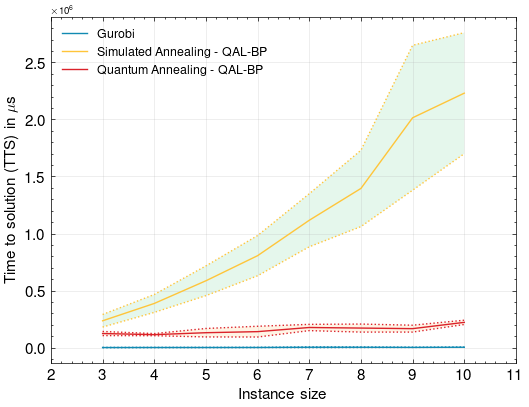

In [22]:
plt.style.use(['science', 'nature'])
runtime = [col for col in df_mean_std_runtime_total.columns if '_mean' in col]

# Legend labels for different solvers
leg = {
    'gurobi_runtime_mean': 'Gurobi',
    'AL_SA_runtime_mean': 'Simulated Annealing - QAL-BP',
    'AL_QA_runtime_mean': 'Quantum Annealing - QAL-BP'
}

color_link = {
    'gurobi_runtime_mean': 'Gurobi',
    'AL_SA_runtime_mean': 'SA',
    'AL_QA_runtime_mean': 'QA'
}


plt.figure(figsize=(6, 4.5))

# Plot TTS for different solvers
for i, r in enumerate(runtime[:3]):
    plt.plot(df_mean_std_runtime_total.loc[:, 'n'], df_mean_std_runtime_total.loc[:, r], color=color_scheme[color_link[r]], label=leg[r])
    r_std = f'{r[:-5]}_std'
    upper_stock = np.sum([np.round(df_mean_std_runtime_total.loc[:, r], 0), np.round(df_mean_std_runtime_total.loc[:, r_std], 0)], 0)
    lower_stock = np.sum([np.round(df_mean_std_runtime_total.loc[:, r], 0), -np.round(df_mean_std_runtime_total.loc[:, r_std], 0)], 0)
    plt.plot(df_mean_std_runtime_total.loc[:, 'n'], upper_stock, color=color_scheme[color_link[r]], linestyle='dotted')
    plt.plot(df_mean_std_runtime_total.loc[:, 'n'], lower_stock, color=color_scheme[color_link[r]], linestyle='dotted')

    plt.fill_between(df_mean_std_runtime_total.loc[:, 'n'], upper_stock, lower_stock, alpha=0.1)

plt.xlim(2, 11)
plt.grid(alpha=0.3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(fontsize=fontsize-2)
plt.tick_params(labelsize=fontsize)
plt.xlabel('Instance size', fontsize=fontsize)
plt.ylabel('Time to solution (TTS) in $\mu$s', fontsize=fontsize)
plt.savefig("tts.png", dpi=dpi)
plt.show()

Plotting the same results in log scale allows to observe also the runtime performance of the exact solver.

<ipython-input-23-79e713523e96>:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 10 ** 12)


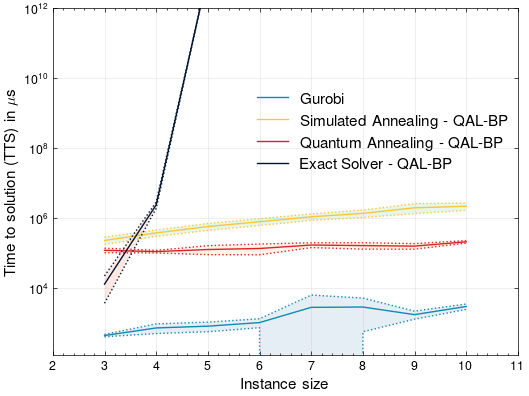

In [23]:
plt.style.use(['science', 'nature'])

runtime = [col for col in df_mean_std_runtime.columns if '_mean' in col]

# Legend labels for different solvers
leg = {
    'gurobi_runtime_mean': 'Gurobi',
    'AL_SA_runtime_mean': 'Simulated Annealing - QAL-BP',
    'AL_QA_runtime_mean': 'Quantum Annealing - QAL-BP',
    'AL_Ex_runtime_mean': 'Exact Solver - QAL-BP'
}

color_link = {
    'gurobi_runtime_mean': 'Gurobi',
    'AL_SA_runtime_mean': 'SA',
    'AL_QA_runtime_mean': 'QA',
    'AL_Ex_runtime_mean': 'Ex'
}

plt.figure(figsize=(6, 4.5))

for i, r in enumerate(runtime[:4]):
    plt.plot(df_mean_std_runtime.loc[:, 'n'], df_mean_std_runtime.loc[:, r], color=color_scheme[color_link[r]], label=leg[r])
    r_std = f'{r[:-5]}_std'
    upper_stock = np.sum([np.round(df_mean_std_runtime.loc[:, r], 0), np.round(df_mean_std_runtime.loc[:, r_std], 0)], 0)
    lower_stock = np.sum([np.round(df_mean_std_runtime.loc[:, r], 0), -np.round(df_mean_std_runtime.loc[:, r_std], 0)], 0)
    plt.plot(df_mean_std_runtime.loc[:, 'n'], upper_stock, color=color_scheme[color_link[r]], linestyle='dotted')
    plt.plot(df_mean_std_runtime.loc[:, 'n'], lower_stock, color=color_scheme[color_link[r]], linestyle='dotted')

    plt.fill_between(df_mean_std_runtime.loc[:, 'n'], upper_stock, lower_stock, alpha=0.1)

plt.yscale('log')
plt.ylim(0, 10 ** 12)

plt.xlim(2, 11)
plt.grid(alpha=0.3)
plt.legend(fontsize=fontsize, bbox_to_anchor=(1.01, .8), ncol=1)
plt.tick_params(labelsize=fontsize-2)
plt.xlabel('Instance size', fontsize=fontsize)
plt.ylabel('Time to solution (TTS) in $\mu$s', fontsize=fontsize)
plt.savefig("tts_log.png", dpi=dpi)
plt.show()


## Minimum eigenvalues distribution

Generate a bar plot to compare the energy of the best solutions found by Simulated, Quantum, and Exact solvers.


In [24]:
df_eigen_SA = df_final_SA[['instance_name','seed','AL_SA_min_eigenvalue']]
df_eigen_QA = df_final_QA[['AL_QA_min_eigenvalue','AL_QA_cbf']]
df_eigen = pd.concat([df_eigen_SA, df_eigen_QA], axis=1)
df_eigen.head()

,instance_name,seed,AL_SA_min_eigenvalue,AL_QA_min_eigenvalue,AL_QA_cbf
0,bpp_3_10,23,0.1334,0.1334,0.0
1,bpp_4_10,23,0.0059,0.0059,0.0
2,bpp_5_10,23,-0.0107,-0.0107,0.0
3,bpp_6_10,23,0.2115,0.2115,0.0
4,bpp_7_10,23,0.5376,0.5376,0.0


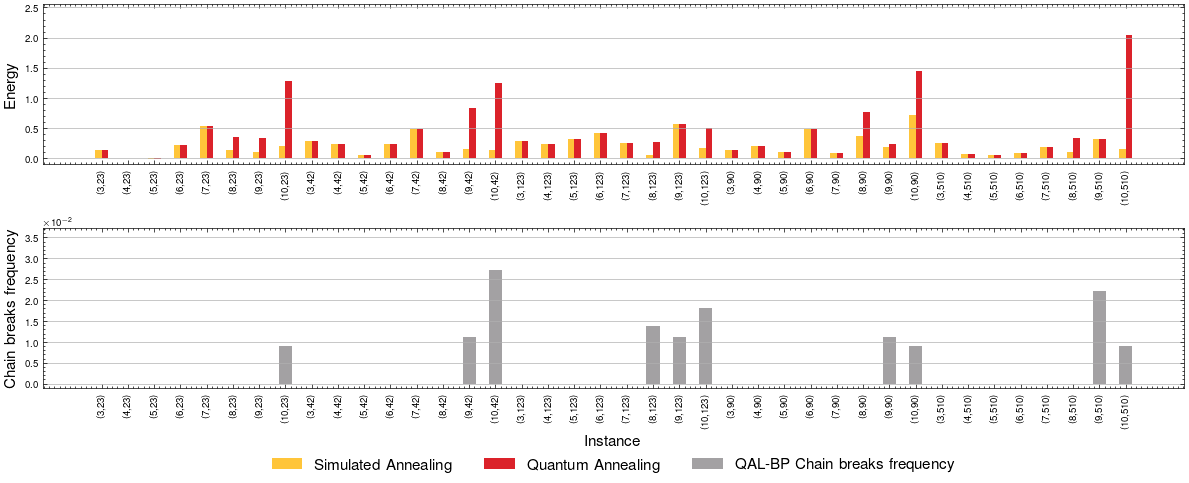

In [25]:
N = 40
ind = np.arange(N)  # the x locations for the groups
width = 0.25        # the width of the bars

plt.style.use(['science', 'nature'])

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
rects1 = ax.bar(ind - width / 2, df_eigen['AL_SA_min_eigenvalue'], width, color=color_scheme['SA'],zorder=1)
rects2 = ax.bar(ind + width / 2, df_eigen['AL_QA_min_eigenvalue'], width, color=color_scheme['QA'],zorder=1)
rects3 = ax2.bar(ind, df_eigen['AL_QA_cbf'], width*2, color=color_scheme['color11'], alpha=.5, zorder=-1)

ax.set_ylabel('Energy', fontsize=fontsize)
ax2.set_ylabel('Chain breaks frequency', fontsize=fontsize)
ax2.set_xlabel('Instance', fontsize=fontsize)
ax.set_ylim(-.1, np.max(df_eigen['AL_QA_min_eigenvalue'])+.5)
ax2.set_ylim(-0.001, np.max(df_eigen['AL_QA_cbf'])+.01)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax.set_xticks(ind)
ax2.set_xticks(ind)
ax.set_xticklabels('('+df_eigen['instance_name'].apply(lambda x: x.split('_')[1])+','+df_eigen['seed'].astype(str)+')', rotation=90)
ax2.set_xticklabels('('+df_eigen['instance_name'].apply(lambda x: x.split('_')[1])+','+df_eigen['seed'].astype(str)+')', rotation=90)
ax2.legend((rects1[0], rects2[0], rects3[0]), ('Simulated Annealing', 'Quantum Annealing', 'QAL-BP Chain breaks frequency'), fontsize=fontsize, loc='upper center', bbox_to_anchor=(0.5, -.35), ncol=3)

plt.tight_layout()
ax.grid(axis='y')
ax2.grid(axis='y')
plt.savefig("minimum_eigenvals.png", dpi=dpi)
plt.show()


## Feasibility density

What follows is a bar plot to visualize the probability of finding feasible solutions for different instance sizes.

In [29]:
df_feasible_density_SA = df_final_SA.groupby('instance_name', sort=False)['AL_SA_feasible'].apply(lambda x: (x==True).sum())/len(seeds)
df_feasible_density_QA = df_final_QA.groupby('instance_name', sort=False)['AL_QA_feasible'].apply(lambda x: (x==True).sum())/len(seeds)
df_feasible_density = pd.concat([df_feasible_density_SA, df_feasible_density_QA], axis=1)
df_feasible_density.head()

,AL_SA_feasible,AL_QA_feasible
instance_name,,
bpp_3_10,1.0,1.0
bpp_4_10,1.0,1.0
bpp_5_10,1.0,1.0
bpp_6_10,1.0,1.0
bpp_7_10,1.0,1.0


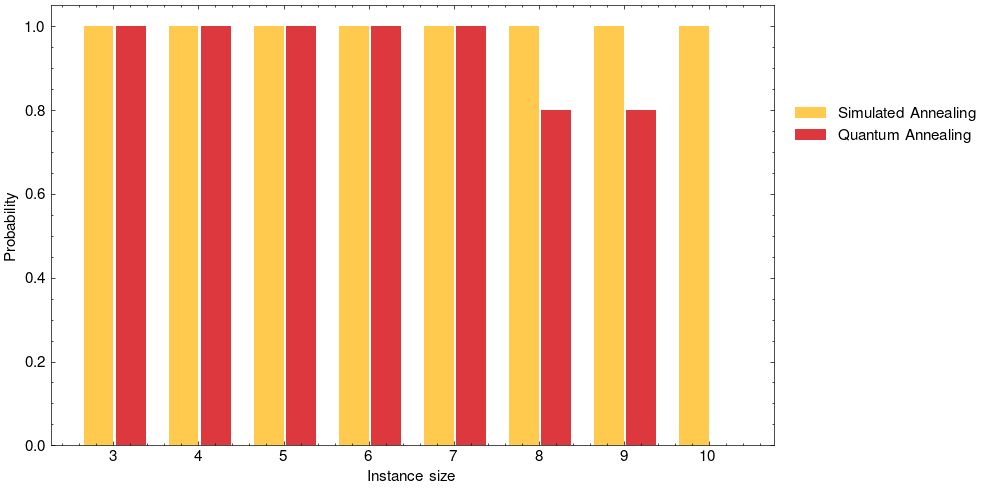

In [30]:
N = 8
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
plt.style.use(['science', 'nature'])
font = 11
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, df_feasible_density['AL_SA_feasible'], width, color=color_scheme['SA'], alpha=.9)
rects2 = ax.bar(ind + width + 0.03, df_feasible_density['AL_QA_feasible'], width, color=color_scheme['QA'], alpha=.9)

ax.set_ylabel('Probability', fontsize=font)
ax.set_xlabel('Instance size', fontsize=font)

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(df_feasible_density.index.to_series().apply(lambda x: x.split('_')[1]), fontsize=font)
plt.yticks(fontsize=font)
plt.xticks(rotation=0)
ax.legend((rects1[0], rects2[0]), ('Simulated Annealing', 'Quantum Annealing'), fontsize=font, bbox_to_anchor=(1.01, .8), ncol=1)
plt.tight_layout()
plt.savefig("feasible_density.png", dpi=dpi)
plt.show()


## Chain breaks analysis

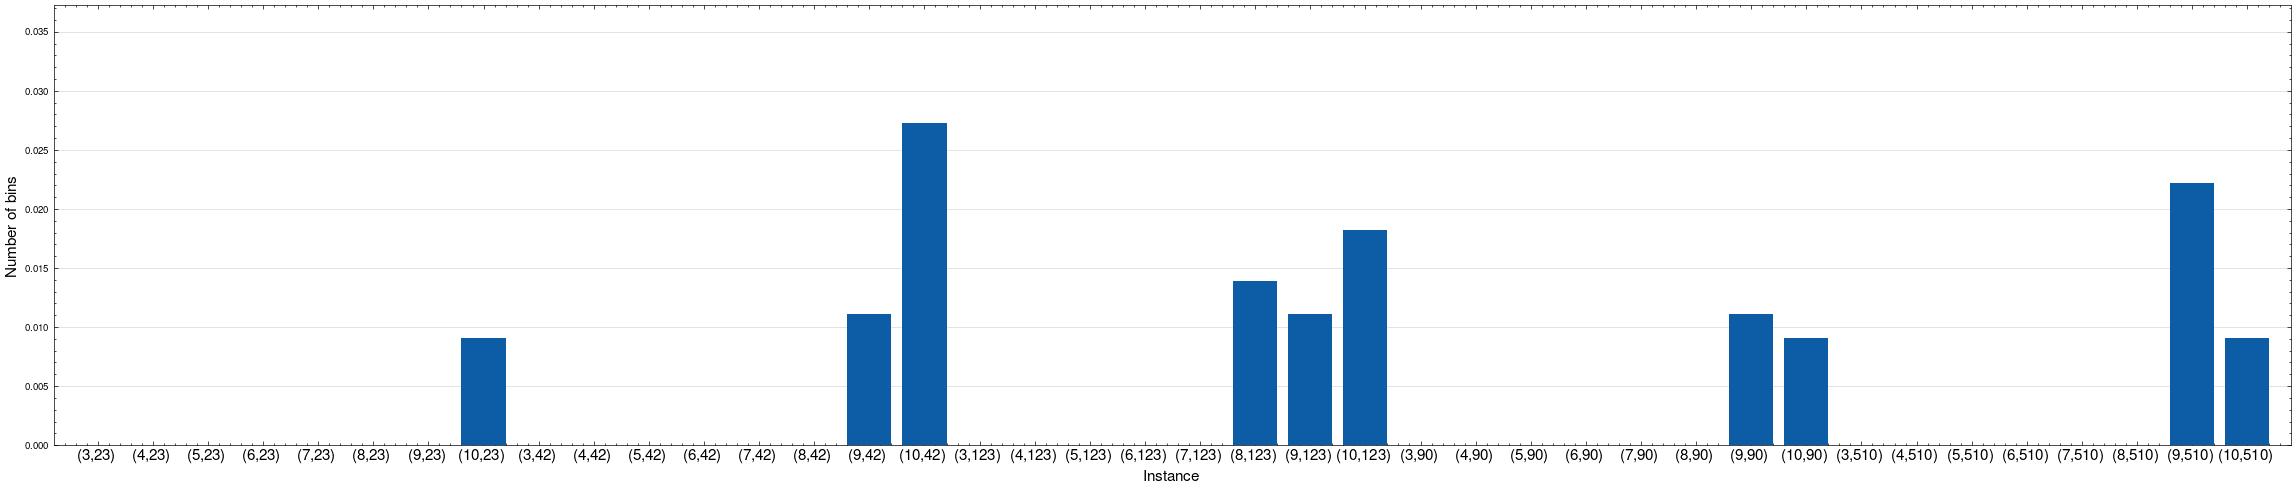

In [31]:
N = 40
ind = np.arange(N)  # the x locations for the groups
# width = 0.35       # the width of the bars
plt.style.use(['science', 'nature'])
font = 11
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)
plt.grid(axis='y', alpha=0.5, zorder=1)
ax.bar(ind, df_final_QA['AL_QA_cbf'], zorder=3)#, color='royalblue', alpha=.9, width=1)

plt.ylabel('Chain Break Frequency', fontsize=font)
plt.xlabel('Instance', fontsize=font)
ax.set_ylabel('Number of bins', fontsize=font)
ax.set_ylim(0, np.max(df_final_QA['AL_QA_cbf'])+.01)
ax.set_xticks(ind)
ax.set_xticklabels('('+df_final_QA['instance_name'].apply(lambda x: x.split('_')[1])+','+df_final_QA['seed'].astype(str)+')', fontsize=font)

plt.gca().margins(x=0.01)
plt.gcf().canvas.draw()
tl = plt.gca().get_xticklabels()
maxsize = max([t.get_window_extent().width for t in tl])
m = 0.2  # inch margin
s = maxsize / plt.gcf().dpi * N + 2 * m
margin = m / plt.gcf().get_size_inches()[0]

plt.gcf().subplots_adjust(left=margin, right=1. - margin)
plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])
plt.tight_layout()

plt.savefig("chain_breaks_frequency.png", dpi=dpi)
plt.show()


In [33]:
df_mean_std_cbf_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)[
       'AL_QA_cbf',
].agg(['mean', 'std'])

df_mean_std_cbf_QA.columns = df_mean_std_cbf_QA.columns.map('_'.join)
df_mean_std_cbf_QA = df_mean_std_cbf_QA.reset_index()
display(df_mean_std_cbf_QA)

,instance_name,n,AL_QA_cbf_mean,AL_QA_cbf_std
0,bpp_3_10,3,0.000000,0.000000
1,bpp_4_10,4,0.000000,0.000000
2,bpp_5_10,5,0.000000,0.000000
3,bpp_6_10,6,0.000000,0.000000
4,bpp_7_10,7,0.000000,0.000000
5,bpp_8_10,8,0.002778,0.006211
6,bpp_9_10,9,0.011111,0.007857
7,bpp_10_10,10,0.014546,0.008131


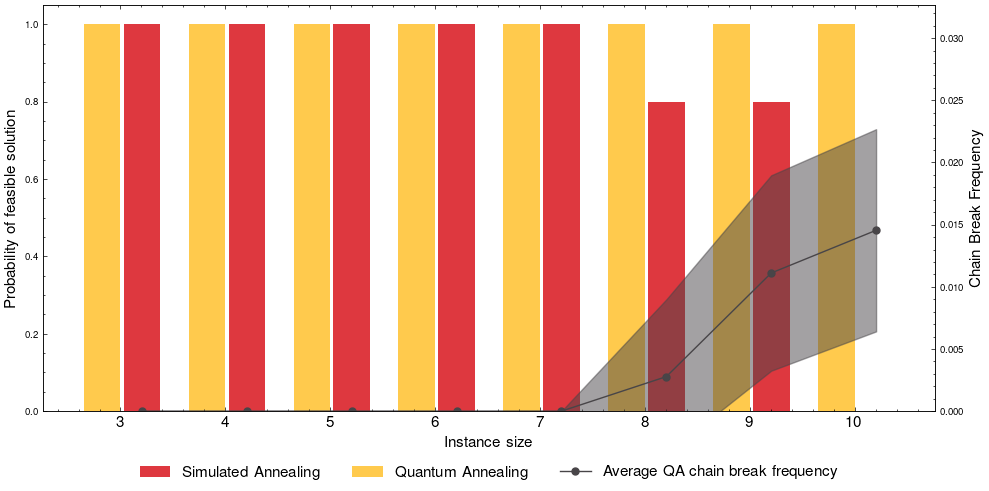

In [34]:
N = 8
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
plt.style.use(['science', 'nature'])
font = 11
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
rects1 = ax.bar(ind + width + 0.03, df_feasible_density['AL_QA_feasible'], width, color=color_scheme['QA'], alpha=.9)
rects2 = ax.bar(ind, df_feasible_density['AL_SA_feasible'], width, color=color_scheme['SA'], alpha=.9)
line = ax2.plot(ind + width + 0.03, df_mean_std_cbf_QA['AL_QA_cbf_mean'], width, color=color_scheme['color11'], alpha=1, marker=".", markersize=10)
ax2.fill_between(ind + width + 0.03, df_mean_std_cbf_QA['AL_QA_cbf_mean'] + df_mean_std_cbf_QA['AL_QA_cbf_std'], df_mean_std_cbf_QA['AL_QA_cbf_mean'] - df_mean_std_cbf_QA['AL_QA_cbf_std'], alpha = .5, color=color_scheme['color11'])

ax.set_ylabel('Probability of feasible solution', fontsize=font)
ax.set_xlabel('Instance size', fontsize=font)
ax2.set_ylabel('Chain Break Frequency', fontsize=font)
ax2.set_ylim(0, np.max(df_mean_std_cbf_QA['AL_QA_cbf_mean'] + df_mean_std_cbf_QA['AL_QA_cbf_std']+.01))
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(df_feasible_density.index.to_series().apply(lambda x: x.split('_')[1]), fontsize=font)
ax.tick_params(axis='x', labelsize=font)
ax2.tick_params(axis='x', labelsize=font)
plt.xticks(rotation=0)
ax.legend((rects1[0], rects2[0], line[0]), ('Simulated Annealing', 'Quantum Annealing', 'Average QA chain break frequency'), fontsize=font, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.tight_layout()
plt.savefig("feasible_density_cbf.png", dpi=300)
plt.show()

## Runtime metrics

In [35]:
df_mean_std_runtime_metrics_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)[
       'AL_QA_runtime_metrics_qpu_sampling_time',
       'AL_QA_runtime_metrics_qpu_anneal_time_per_sample',
       'AL_QA_runtime_metrics_qpu_readout_time_per_sample',
      #  'AL_QA_runtime_metrics_qpu_access_time',
      #  'AL_QA_runtime_metrics_qpu_access_overhead_time',
       'AL_QA_runtime_metrics_qpu_programming_time',
       'AL_QA_runtime_metrics_qpu_delay_time_per_sample',
      #  'AL_QA_runtime_metrics_total_post_processing_time',
       'AL_QA_runtime_metrics_post_processing_overhead_time',
       'AL_QA_qubo_time'
       ].agg(['mean', 'std'])

df_mean_std_runtime_metrics_QA.columns = df_mean_std_runtime_metrics_QA.columns.map('_'.join)
df_mean_std_runtime_metrics_QA = df_mean_std_runtime_metrics_QA.reset_index()
display(df_mean_std_runtime_metrics_QA)

<ipython-input-35-9a0bec5bfb5d>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_metrics_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)[


,instance_name,n,AL_QA_runtime_metrics_qpu_sampling_time_mean,AL_QA_runtime_metrics_qpu_sampling_time_std,AL_QA_runtime_metrics_qpu_anneal_time_per_sample_mean,AL_QA_runtime_metrics_qpu_anneal_time_per_sample_std,AL_QA_runtime_metrics_qpu_readout_time_per_sample_mean,AL_QA_runtime_metrics_qpu_readout_time_per_sample_std,AL_QA_runtime_metrics_qpu_programming_time_mean,AL_QA_runtime_metrics_qpu_programming_time_std,AL_QA_runtime_metrics_qpu_delay_time_per_sample_mean,AL_QA_runtime_metrics_qpu_delay_time_per_sample_std,AL_QA_runtime_metrics_post_processing_overhead_time_mean,AL_QA_runtime_metrics_post_processing_overhead_time_std,AL_QA_qubo_time_mean,AL_QA_qubo_time_std
0,bpp_3_10,3,122908.0,18100.721533,20.0,0.0,82.368,18.100722,15762.93,0.219089,20.54,0.0,1495.4,718.015877,257.539749,69.151541
1,bpp_4_10,4,112896.0,9356.488658,20.0,0.0,72.356,9.356489,15762.69,0.334664,20.54,0.0,727.0,246.926102,515.890122,141.379343
2,bpp_5_10,5,129504.0,37251.776870,20.0,0.0,88.964,37.251777,15763.17,0.748331,20.54,0.0,2119.8,821.324357,874.280930,317.753161
3,bpp_6_10,6,138624.0,47217.599261,20.0,0.0,98.084,47.217599,15763.33,1.846077,20.54,0.0,2628.4,1235.262037,1139.402390,335.846442
4,bpp_7_10,7,173888.0,27245.853262,20.0,0.0,133.348,27.245853,15763.25,0.954987,20.54,0.0,2556.2,1260.533300,2231.884003,722.663279
5,bpp_8_10,8,167736.0,34790.131934,20.0,0.0,127.196,34.790132,15764.45,0.912140,20.54,0.0,2776.8,1210.364491,3287.124634,706.037734
6,bpp_9_10,9,161800.0,29347.238371,20.0,0.0,121.260,29.347238,15764.21,2.920274,20.54,0.0,3381.4,982.312730,4179.763794,989.275143
7,bpp_10_10,10,215120.0,18096.601891,20.0,0.0,174.580,18.096602,15763.49,2.613809,20.54,0.0,4104.8,980.421950,5940.866470,1833.919766


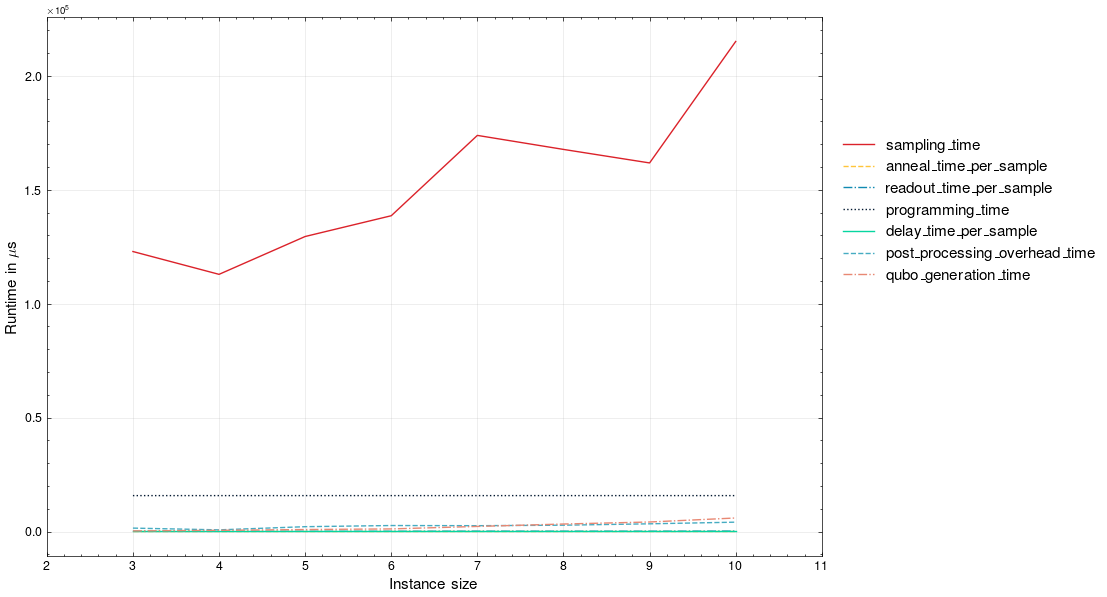

In [36]:
plt.style.use(['science', 'nature'])
runtime = [col for col in df_mean_std_runtime_metrics_QA.columns if '_mean' in col]

# Legend labels for different solvers
leg = {

    'AL_QA_runtime_metrics_qpu_sampling_time_mean' : 'sampling_time',
    'AL_QA_runtime_metrics_qpu_anneal_time_per_sample_mean' : 'anneal_time_per_sample',
    'AL_QA_runtime_metrics_qpu_readout_time_per_sample_mean' : 'readout_time_per_sample',
    'AL_QA_runtime_metrics_qpu_access_time_mean' : 'access_time',
    'AL_QA_runtime_metrics_qpu_access_overhead_time_mean' : 'access_overhead_time',
    'AL_QA_runtime_metrics_qpu_programming_time_mean' : 'programming_time',
    'AL_QA_runtime_metrics_qpu_delay_time_per_sample_mean' : 'delay_time_per_sample',
    'AL_QA_runtime_metrics_total_post_processing_time_mean' : 'total_post_processing_time',
    'AL_QA_runtime_metrics_post_processing_overhead_time_mean' : 'post_processing_overhead_time',
    'AL_QA_qubo_time_mean' : 'qubo_generation_time'
}

lines = ["-","--","-.",":"]
linecycler = cycle(lines)

plt.figure(figsize=(10, 7))

# Plot runtime metrics
for i, r in enumerate(runtime):
  plt.plot(df_mean_std_runtime_metrics_QA.loc[:, 'n'], df_mean_std_runtime_metrics_QA.loc[:, r], label=leg[r], linestyle=next(linecycler), color=list(color_scheme.values())[i])

plt.xlim(2, 11)
plt.grid(alpha=0.3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(fontsize=font)
plt.tick_params(labelsize=9)
plt.xlabel('Instance size', fontsize=font)
plt.ylabel('Runtime in $\mu$s', fontsize=font)
plt.legend(fontsize=font, bbox_to_anchor=(1.01, .8), ncol=1)
plt.savefig("runtime_metrics.png", dpi=dpi)
plt.show()


## Physical vs logical qubits

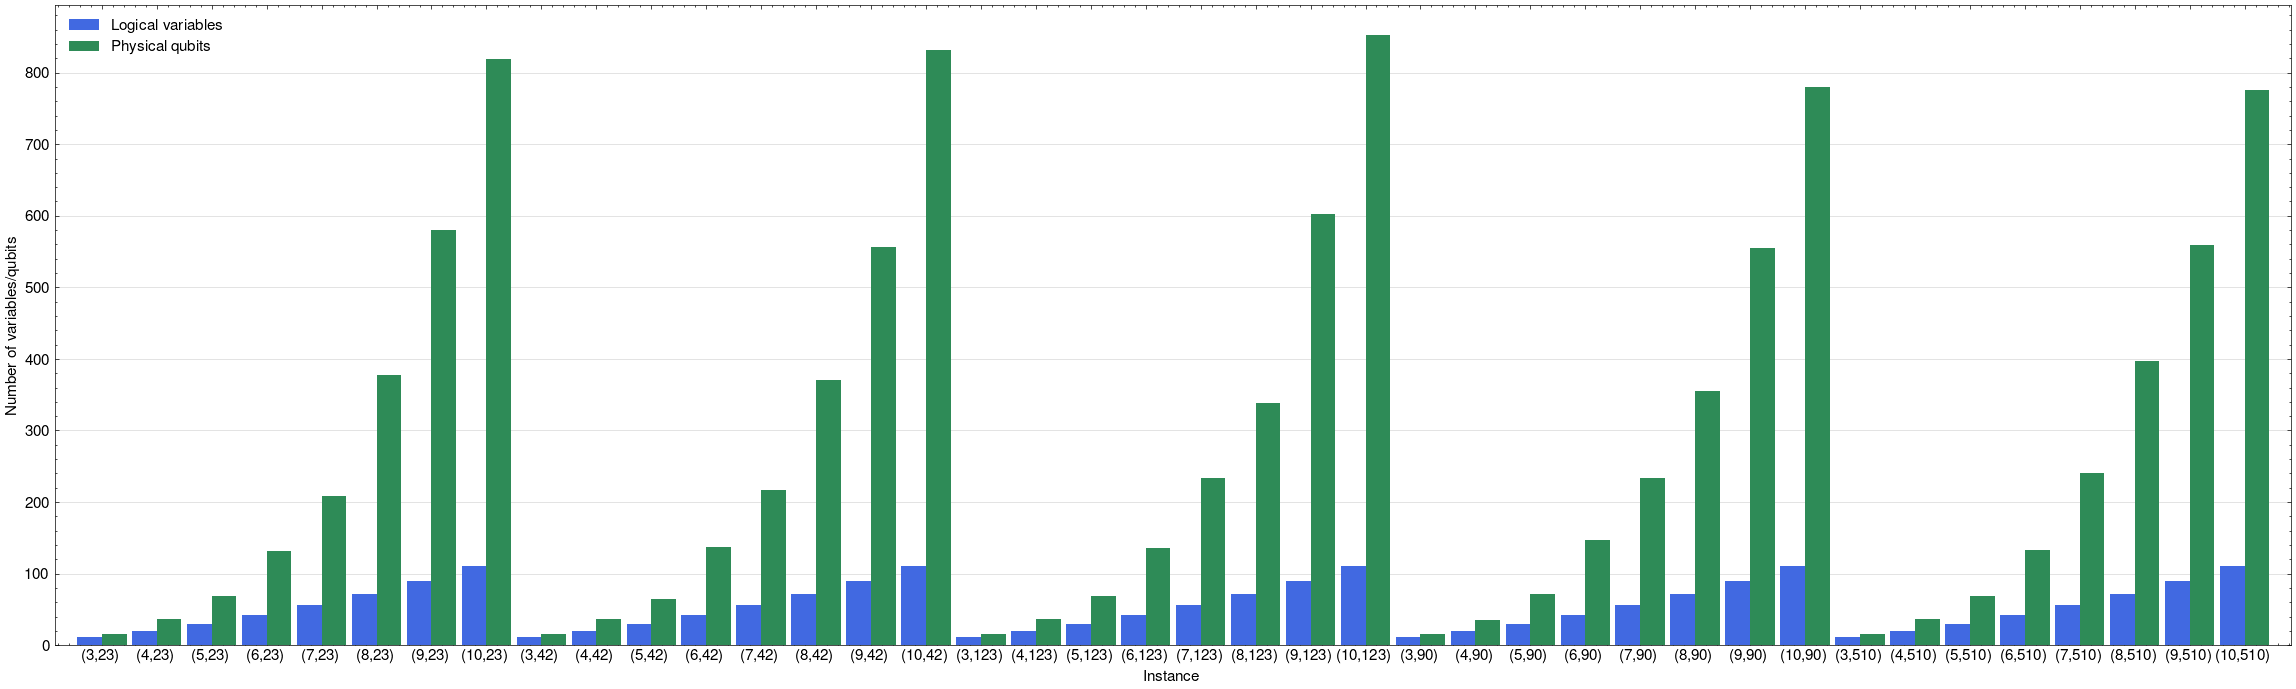

In [37]:
N = 40
ind = np.arange(N)  # the x locations for the groups
width = 0.45        # the width of the bars

plt.style.use(['science', 'nature'])

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
plt.grid(axis='y', alpha=0.5, zorder=1)
rects1 = ax.bar(ind, df_final_QA['AL_QA_logiqu'], width, color='royalblue', zorder=3)
rects2 = ax.bar(ind + width, df_final_QA['AL_QA_physiqu'], width, color='seagreen', zorder=3)

# Add labels and titles
ax.set_ylabel('Number of variables/qubits', fontsize=font)
ax.set_xlabel('Instance', fontsize=font)
ax.set_xticks(ind + width/2)
ax.set_xticklabels('('+df_final_QA['instance_name'].apply(lambda x: x.split('_')[1])+','+df_final_QA['seed'].astype(str)+')', fontsize=fontsize)
plt.xticks(rotation=0)
plt.yticks(fontsize=font)

plt.gca().margins(x=0.01)
plt.gcf().canvas.draw()
tl = plt.gca().get_xticklabels()
maxsize = max([t.get_window_extent().width for t in tl])
m = 0.2  # inch margin
s = maxsize / plt.gcf().dpi * N + 2 * m
margin = m / plt.gcf().get_size_inches()[0]

plt.gcf().subplots_adjust(left=margin, right=1. - margin)
plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

ax.legend((rects1[0], rects2[0]), ('Logical variables', 'Physical qubits'), loc='upper left', fontsize=font)
plt.tight_layout()

plt.savefig("qubits.png", dpi=dpi)
plt.show()